# Notebook for Regression Analysis of IPL 2008-2019 Data

Start by importing all of the necessary packages 

In [ ]:
import os, glob
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

Import the preprocessed data into the notebook and merge all of the files together 
Info on how to import and merge was learned from the following link
https://blog.softhints.com/how-to-merge-multiple-csv-files-with-python/

In [2]:
path = "C:/Users/44747/Documents/Data Science/Cricket/Jupyter/All bat and bowl"

# Import all of the Batting csv's
batting = glob.glob(os.path.join(path, "bat_*.csv"))
batting_files = (pd.read_csv(f, sep=',') for f in batting)
batting_all   = pd.concat(batting_files, ignore_index=True)

# Import all of the bowling files
bowling = glob.glob(os.path.join(path, "bowl_*.csv"))
bowling_files = (pd.read_csv(f, sep=',') for f in bowling)
bowling_all   = pd.concat(bowling_files, ignore_index=True)

# Merge all of the batting and the bowling files together and view

merged = batting_all.merge(bowling_all, on=['Season', 'Team'])
merged.head()

,Unnamed: 0_x,Season,Avg_SR,RPG,PowerPlay_x,PP_WLost,RunsPWBat,BoundPG,DotsPG_x,Points,...,Unnamed: 0_y,Bowl_SR,RPB,PowerPlay_y,PP_Economy,Death_Econ,Death_W,RunsPWBowl,WPG,DotsPG_y
0,0,2008,1.344717,157.500000,45.1250,1.000000,31.898734,20.625000,42.375000,16,...,0,20.516129,1.345912,1.437500,41.625000,32.625000,2.250000,27.612903,5.8125,40.812500
1,1,2009,1.305442,159.357143,51.0000,1.142857,27.543210,18.928571,42.000000,17,...,1,17.868132,1.232472,1.714286,47.571429,31.428571,1.500000,22.021978,6.5000,43.785714
2,2,2010,1.334700,162.750000,47.6875,1.500000,29.258427,19.437500,40.875000,14,...,2,19.165049,1.275076,1.500000,44.875000,37.062500,2.000000,24.436893,6.4375,45.562500
3,3,2011,1.314843,160.000000,38.3750,1.312500,34.594595,18.500000,39.687500,18,...,3,20.593407,1.227321,1.500000,45.937500,28.750000,1.812500,25.274725,5.6875,41.937500
4,4,2012,1.296839,157.277778,44.5000,0.944444,28.029703,18.055556,41.833333,17,...,4,19.555556,1.241004,1.166667,46.166667,25.833333,2.277778,24.268519,6.0000,40.888889


In [3]:
# Remove unwanted columns
del merged['Unnamed: 0_x']
del merged['Unnamed: 0_y']

In [4]:
# Rename columns and view dataframe

cricket = merged.rename(columns={"RPG": "RPG_Bat", "PowerPlay_x": "PP_Batting_Avg", "PP_WLost": "PP_Avg_WLost", "DotsPG_x": "DotsPG_Bat", "RPB": "RPB_Bowl", "PowerPlay_y": "PP_Avg_RPB_Bowl", "PP_Economy": "PP_Avg_Runs_Bowl", "DotsPG_y": "AvgDots_PG_Bowl"})
cricket

,Season,Avg_SR,RPG_Bat,PP_Batting_Avg,PP_Avg_WLost,RunsPWBat,BoundPG,DotsPG_Bat,Points,Team,Bowl_SR,RPB_Bowl,PP_Avg_RPB_Bowl,PP_Avg_Runs_Bowl,Death_Econ,Death_W,RunsPWBowl,WPG,AvgDots_PG_Bowl
0,2008,1.344717,157.500000,45.125000,1.000000,31.898734,20.625000,42.375000,16,CSK,20.516129,1.345912,1.437500,41.625000,32.625000,2.250000,27.612903,5.812500,40.812500
1,2009,1.305442,159.357143,51.000000,1.142857,27.543210,18.928571,42.000000,17,CSK,17.868132,1.232472,1.714286,47.571429,31.428571,1.500000,22.021978,6.500000,43.785714
2,2010,1.334700,162.750000,47.687500,1.500000,29.258427,19.437500,40.875000,14,CSK,19.165049,1.275076,1.500000,44.875000,37.062500,2.000000,24.436893,6.437500,45.562500
3,2011,1.314843,160.000000,38.375000,1.312500,34.594595,18.500000,39.687500,18,CSK,20.593407,1.227321,1.500000,45.937500,28.750000,1.812500,25.274725,5.687500,41.937500
4,2012,1.296839,157.277778,44.500000,0.944444,28.029703,18.055556,41.833333,17,CSK,19.555556,1.241004,1.166667,46.166667,25.833333,2.277778,24.268519,6.000000,40.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015,1.330524,157.857143,50.428571,1.357143,27.283951,18.857143,40.214286,14,SRH,19.835443,1.356733,1.214286,47.500000,32.714286,1.642857,26.911392,5.642857,38.071429
96,2016,1.314159,157.235294,47.058824,1.000000,27.556701,18.882353,41.117647,16,SRH,20.469388,1.286142,1.529412,41.705882,31.058824,1.764706,26.326531,5.764706,39.411765
97,2017,1.399047,167.785714,48.714286,0.785714,37.887097,20.785714,36.214286,17,SRH,16.791667,1.343672,1.642857,50.142857,30.928571,2.500000,22.562500,6.857143,37.500000
98,2018,1.370299,167.176471,49.470588,1.529412,28.707071,19.529412,39.823529,18,SRH,19.504762,1.343262,1.294118,47.823529,33.941176,1.823529,26.200000,6.176471,43.117647


In [5]:
# Reorder columns into more meaningful order

cricket = cricket[['Avg_SR', 'RPG_Bat', 'PP_Batting_Avg', 'PP_Avg_WLost', 'RunsPWBat', 'BoundPG', 'DotsPG_Bat', 'Bowl_SR' , 'RPB_Bowl', 'PP_Avg_RPB_Bowl', 'PP_Avg_Runs_Bowl', 'Death_Econ', 'Death_W' ,'RunsPWBowl', 'WPG', 'AvgDots_PG_Bowl', 'Season', 'Team', 'Points']]
cricket.head()

,Avg_SR,RPG_Bat,PP_Batting_Avg,PP_Avg_WLost,RunsPWBat,BoundPG,DotsPG_Bat,Bowl_SR,RPB_Bowl,PP_Avg_RPB_Bowl,PP_Avg_Runs_Bowl,Death_Econ,Death_W,RunsPWBowl,WPG,AvgDots_PG_Bowl,Season,Team,Points
0,1.344717,157.500000,45.1250,1.000000,31.898734,20.625000,42.375000,20.516129,1.345912,1.437500,41.625000,32.625000,2.250000,27.612903,5.8125,40.812500,2008,CSK,16
1,1.305442,159.357143,51.0000,1.142857,27.543210,18.928571,42.000000,17.868132,1.232472,1.714286,47.571429,31.428571,1.500000,22.021978,6.5000,43.785714,2009,CSK,17
2,1.334700,162.750000,47.6875,1.500000,29.258427,19.437500,40.875000,19.165049,1.275076,1.500000,44.875000,37.062500,2.000000,24.436893,6.4375,45.562500,2010,CSK,14
3,1.314843,160.000000,38.3750,1.312500,34.594595,18.500000,39.687500,20.593407,1.227321,1.500000,45.937500,28.750000,1.812500,25.274725,5.6875,41.937500,2011,CSK,18
4,1.296839,157.277778,44.5000,0.944444,28.029703,18.055556,41.833333,19.555556,1.241004,1.166667,46.166667,25.833333,2.277778,24.268519,6.0000,40.888889,2012,CSK,17


Define what column names mean: 
<br>
Variables are created from ball-by-ball data of 10 Indian Premier League Seasons 
<br>
Each row represents these statistics for one team for one season
<br>
I created these variables as I thought they were important statistics
<br>
<br>
AVG_SR: Average strike rate over one season for a team
<br>
RPG_Bat: Runs per game, when batting
<br>
PP_Batting_Avg: Average batting score in the first 6 overs of a game
<br>
PP_Avg_WLost: Average wickets lost in the first 6 overs of a game, when batting (lower better)
<br>
RunsPWBat: Average runs per wicket lost when batting
<br>
BoundPG: Average boundaries scored per game
<br>
DotsPG_Bat: Average dot balls conceded per game when batting (lower better)
<br>
Bowl_SR: Bowling strike rate. Balls per wicket when bowling (lower better)
<br>
RPB_Bowl: Runs per ball, when bowling (lower better)
<br>
PP_Avg_RPB_Bowl: Average runs per ball conceded in the first 6 overs when bowling (lower better)
<br>
PP_Avg_Runs_Bowl: Average runs conceded in the first 6 overs, when bowling (lower better)
<br>
Death_Econ: Average runs conceded in per ball in the final 4 overs (lower better)
<br>
Death_W: Average wickets taken in the final 4 overs of a game
<br>
RunsPWBowl: Average runs conceded per wicket, when bowling (lower better)
<br>
WPG: Average wickets taken per game
<br>
AvgDots_PG_Bowl: Average dot balls per game when bowling


In [6]:
cricket.head()

,Avg_SR,RPG_Bat,PP_Batting_Avg,PP_Avg_WLost,RunsPWBat,BoundPG,DotsPG_Bat,Bowl_SR,RPB_Bowl,PP_Avg_RPB_Bowl,PP_Avg_Runs_Bowl,Death_Econ,Death_W,RunsPWBowl,WPG,AvgDots_PG_Bowl,Season,Team,Points
0,1.344717,157.500000,45.1250,1.000000,31.898734,20.625000,42.375000,20.516129,1.345912,1.437500,41.625000,32.625000,2.250000,27.612903,5.8125,40.812500,2008,CSK,16
1,1.305442,159.357143,51.0000,1.142857,27.543210,18.928571,42.000000,17.868132,1.232472,1.714286,47.571429,31.428571,1.500000,22.021978,6.5000,43.785714,2009,CSK,17
2,1.334700,162.750000,47.6875,1.500000,29.258427,19.437500,40.875000,19.165049,1.275076,1.500000,44.875000,37.062500,2.000000,24.436893,6.4375,45.562500,2010,CSK,14
3,1.314843,160.000000,38.3750,1.312500,34.594595,18.500000,39.687500,20.593407,1.227321,1.500000,45.937500,28.750000,1.812500,25.274725,5.6875,41.937500,2011,CSK,18
4,1.296839,157.277778,44.5000,0.944444,28.029703,18.055556,41.833333,19.555556,1.241004,1.166667,46.166667,25.833333,2.277778,24.268519,6.0000,40.888889,2012,CSK,17


# Summary Statistics

In [7]:
cricket.describe()

,Avg_SR,RPG_Bat,PP_Batting_Avg,PP_Avg_WLost,RunsPWBat,BoundPG,DotsPG_Bat,Bowl_SR,RPB_Bowl,PP_Avg_RPB_Bowl,PP_Avg_Runs_Bowl,Death_Econ,Death_W,RunsPWBowl,WPG,AvgDots_PG_Bowl,Season,Points
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.313701,155.703504,46.253267,1.456816,26.998582,18.955855,41.746551,20.586495,1.314924,1.440930,46.129301,33.700153,1.842262,27.139505,5.827694,41.623713,2013.430000,14.360000
std,0.096809,12.006084,4.882934,0.321987,4.358187,2.221696,3.693269,2.375462,0.090067,0.295166,4.927706,4.629793,0.367818,4.195195,0.665671,3.293611,3.420836,4.248636
min,1.102780,129.769231,36.142857,0.666667,18.344086,14.357143,33.600000,15.689320,1.129332,0.714286,29.250000,19.307692,0.923077,20.358491,4.000000,33.857143,2008.000000,4.000000
25%,1.246680,148.522321,42.223214,1.246324,24.006641,17.500000,39.392857,19.033154,1.254870,1.285714,43.037946,31.121849,1.571429,23.917092,5.371795,39.198661,2011.000000,12.000000
50%,1.310064,154.785714,45.629464,1.452083,27.304313,18.878676,41.562500,20.291964,1.308527,1.437500,45.821429,33.562500,1.806250,26.580341,5.870833,42.095833,2013.000000,14.000000
75%,1.377016,163.250000,50.214286,1.714286,29.333025,20.273529,44.589286,21.931424,1.363228,1.642857,49.281250,36.500000,2.125000,29.729452,6.298713,43.857143,2016.000000,18.000000
max,1.556658,186.312500,59.733333,2.428571,41.985915,24.785714,49.615385,29.464286,1.518240,2.538462,59.571429,44.500000,2.647059,44.732143,7.066667,50.411765,2019.000000,22.000000


# Correlation of variables
Use correlation matrix to determine variables to use for Multiple Linear regresion
Use VIF to check variance inflation factor

In [8]:
corr_matrix = cricket.corr()

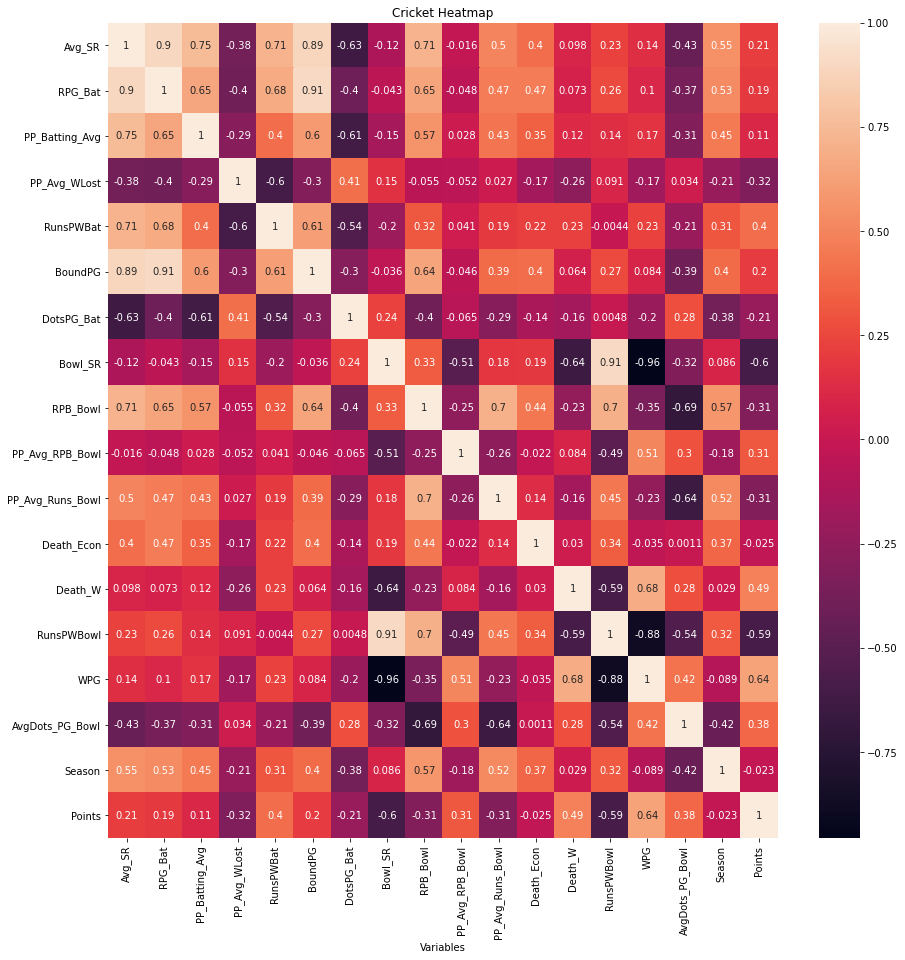

In [9]:
fig, ax = plt.subplots(figsize = (15,15))
sn.heatmap(corr_matrix, annot=True)
plt.xlabel("Variables")
ax.set_title('Cricket Heatmap')
plt.show()

Heatmap highlights some variables for consideration for Multiple Linear Regeression
VIF for further information about multicollinearity
VIF information from https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [10]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [11]:
X = cricket.iloc[:,:-3]
calc_vif(X)

,variables,VIF
0,Avg_SR,4477.424306
1,RPG_Bat,1716.658937
2,PP_Batting_Avg,282.901121
3,PP_Avg_WLost,42.901317
4,RunsPWBat,144.976519
5,BoundPG,889.374734
6,DotsPG_Bat,529.899346
7,Bowl_SR,2622.831447
8,RPB_Bowl,3956.068801
9,PP_Avg_RPB_Bowl,43.836596


Very high VIF values shows the issue of multicollinearity of the variables
From correlation matrix, WPG, RunsPWBat, Death_W and PP_Avg_Wlost to be used for MLR
Second VIF on these four variables carried out

In [12]:
cricket_MLR = cricket[['RunsPWBat', 'WPG','PP_Avg_WLost', 'Death_W']]
X = cricket_MLR.iloc[:,:]
calc_vif(X)

,variables,VIF
0,RunsPWBat,35.168871
1,WPG,125.168419
2,PP_Avg_WLost,16.555079
3,Death_W,51.385952


#VIF scores still very high - MLR will be used still. But will use other methods to address the multicollinearity. DAta for MLR can be standardised to try and reduce the VIF

# Multiple Linear Regression

In [13]:
cricket_MLR1 = cricket[['RunsPWBat', 'WPG','PP_Avg_WLost', 'Death_W', 'Points']]

In [14]:
DV = ['RunsPWBat', 'WPG', 'PP_Avg_WLost', 'Death_W']

In [15]:
scaler = StandardScaler()

In [16]:
cricket_MLR1[DV] = scaler.fit_transform(cricket_MLR1[DV])

<ipython-input-16-613f47afe709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cricket_MLR1[DV] = scaler.fit_transform(cricket_MLR1[DV])
C:\Users\44747\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
cricket_MLR1

,RunsPWBat,WPG,PP_Avg_WLost,Death_W,Points
0,1.130020,-0.022940,-1.425890,1.114116,16
1,0.125596,1.015055,-0.979981,-0.935206,17
2,0.521141,0.920692,0.134792,0.431008,14
3,1.751710,-0.211666,-0.450464,-0.081322,18
4,0.237786,0.260150,-1.599299,1.190016,17
...,...,...,...,...,...
95,0.065809,-0.279068,-0.311117,-0.544859,14
96,0.128707,-0.095100,-1.425890,-0.211916,16
97,2.510991,1.554273,-2.094754,1.797223,17
98,0.393993,0.526587,0.226597,-0.051185,18


In [18]:
cricket_MLR2 = cricket_MLR1[['RunsPWBat', 'WPG','PP_Avg_WLost', 'Death_W']]
X = cricket_MLR2.iloc[:,:]
calc_vif(X)

,variables,VIF
0,RunsPWBat,1.609277
1,WPG,1.911080
2,PP_Avg_WLost,1.617994
3,Death_W,1.950993


Standardization of the variables has reduced the multicollinearity significantly
Split the data into test and train with 80/20 split. This split as only 100 rows of data, so preferable to 70/30

In [19]:
df_train, df_test = train_test_split(cricket_MLR1, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 100)

In [20]:
y_train = df_train.pop('Points')
X_train = df_train

y_test = df_test.pop('Points')
X_test = df_test

In [21]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = lm.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5117521390469965


In [23]:
print('slope', lm.coef_)

slope [ 0.76754419  2.54880349 -0.33344815 -0.03068225]


In [24]:
model = sm.OLS(y_train,X_train)

In [25]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     16.39
Date:                Sat, 19 Dec 2020   Prob (F-statistic):           1.08e-09
Time:                        17:39:57   Log-Likelihood:                -201.00
No. Observations:                  80   AIC:                             412.0
Df Residuals:                      75   BIC:                             423.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           14.4008      0.346     41.653   

In [26]:
X  = cricket_MLR1[['RunsPWBat', 'WPG', 'PP_Avg_WLost', 'Death_W']]
y= cricket_MLR1['Points']
accuracy = cross_val_score(lm, X, y, scoring='r2', cv = 5)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.4476734  0.55086652 0.38355083 0.31322457 0.2982375 ]
Accuracy of Model with Cross Validation is: 39.87105647102396


In [27]:
# Should I reference this?
explained_variance=metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
mse=metrics.mean_squared_error(y_test, y_pred) 
mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
r2=metrics.r2_score(y_test, y_pred)

In [28]:
# and this?
print('explained_variance: ', round(explained_variance,4))    
print('mean_squared_log_error: ', round(mean_squared_log_error,4))
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

explained_variance:  0.5136
mean_squared_log_error:  0.0699
r2:  0.5118
MAE:  2.7285
MSE:  10.7061
RMSE:  3.272


In [29]:
residual = y_test - y_pred

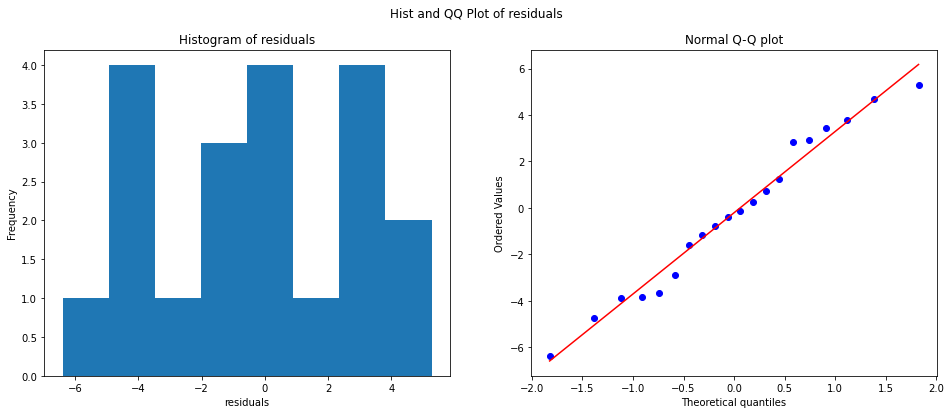

ShapiroResult(statistic=0.9688680171966553, pvalue=0.7308096885681152)

In [30]:
fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].hist(residual,bins=8)
axs[0].set_xlabel("residuals")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of residuals")
fig.suptitle("Hist and QQ Plot of residuals")
stats.probplot(residual, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

shapiro_test = stats.shapiro(residual)
shapiro_test

AssertionError: 

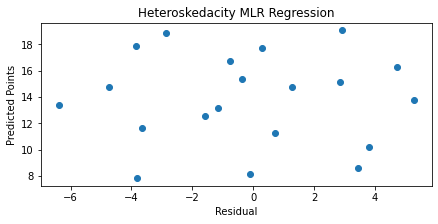

In [89]:
fig, ax = plt.subplots(figsize=(7,3))
ax.scatter(residual, y_pred)
# Variance of errors does seem constant
plt.xlabel("Residual")
plt.ylabel("Predicted Points")
plt.title("Heteroskedacity MLR Regression")


white_test = het_white(residual,X_test)
print(white_test)

,Avg_SR,RPG_Bat,PP_Batting_Avg,PP_Avg_WLost,RunsPWBat,BoundPG,DotsPG_Bat,Bowl_SR,RPB_Bowl,PP_Avg_RPB_Bowl,PP_Avg_Runs_Bowl,Death_Econ,Death_W,RunsPWBowl,WPG,AvgDots_PG_Bowl
37,0.000426,-0.458333,0.080170,-0.628403,0.488479,-0.740916,-1.929537,-0.852292,-0.167222,1.161477,-0.549953,-0.342496,0.790745,-0.706093,0.756943,0.487471
62,-0.230186,0.002536,-1.015306,1.256195,-0.204735,0.348358,1.202281,1.063685,-0.182459,-1.262452,-0.253737,-0.388508,-0.858778,0.676848,-1.035523,-0.645081
26,0.422728,0.606301,1.442416,-0.688917,-0.452607,0.640663,0.240047,-1.004247,0.214114,-0.229528,0.423276,1.373601,1.745731,-0.693621,1.371589,0.617272
41,-1.291473,-1.646910,0.404317,0.737498,-0.965641,-1.330524,0.594555,0.218456,-1.155539,0.626324,-0.965236,-1.682590,-1.044815,-0.311081,-0.490517,1.280542
35,-0.041964,-0.038982,-0.746909,-0.461988,0.166697,-0.093848,-0.575320,-0.213622,-0.859277,-0.022943,-0.885374,-0.060674,0.769040,-0.494335,0.338347,1.384847
25,1.817525,1.359247,1.238346,0.996846,1.081580,1.127838,-1.370429,-0.281341,1.832466,-0.554161,2.505135,-0.095182,-0.300669,0.427313,0.054490,-1.137184
36,0.528889,0.043242,0.931216,-0.479444,-0.188419,0.733486,-0.856198,-0.539694,0.055276,1.025873,0.009864,1.732460,0.243130,-0.402377,0.515649,0.536626
33,-0.939733,-0.739897,-0.439106,-0.742313,-0.106314,-1.103028,-0.247922,-0.720757,-1.860861,-0.290288,-1.181333,-0.522483,2.128748,-1.180792,0.791852,0.767043
77,2.165481,2.335263,0.417626,-1.369707,2.802740,2.004754,-1.762919,-0.540167,0.610389,0.803397,0.296222,1.207527,-0.533215,-0.210596,0.656268,-0.955320
21,-0.894723,-0.633599,-1.423448,0.737498,-0.568920,-0.790883,0.473009,1.655648,0.560656,-1.498549,-0.064972,0.215397,-1.044815,1.448729,-1.762198,-1.179976


In [34]:
# Ridge regression to be used to reduce the effect of multicollinearity

# Ridge Regression

In [35]:
# Lose the varibles not needed for the regression
cricket_ridge = cricket.drop(['Team', 'Season'], axis=1)

In [36]:
# Define scaler
scaler = StandardScaler()

In [37]:
# Define dependent variables
DV = ['Avg_SR', 'RPG_Bat', 'PP_Batting_Avg', 'PP_Avg_WLost', 'RunsPWBat', 'BoundPG', 'DotsPG_Bat', 'Bowl_SR' , 'RPB_Bowl', 'PP_Avg_RPB_Bowl', 'PP_Avg_Runs_Bowl', 'Death_Econ', 'Death_W' ,'RunsPWBowl', 'WPG', 'AvgDots_PG_Bowl']

In [38]:
# Divide into Test and train
df_train, df_test = train_test_split(cricket_ridge, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 100)

In [39]:
# Standardise training set
df_train[DV] = scaler.fit_transform(df_train[DV])

<ipython-input-39-28885e2d9984>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[DV] = scaler.fit_transform(df_train[DV])
C:\Users\44747\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [40]:
# Standardise test set
df_test[DV] = scaler.fit_transform(df_test[DV])

<ipython-input-40-2ab923bc562f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[DV] = scaler.fit_transform(df_test[DV])
C:\Users\44747\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [41]:
# Define test and train set 
y_train1 = df_train.pop('Points')
X_train1 = df_train

y_test1 = df_test.pop('Points')
X_test1 = df_test

In [42]:
# Set ridge 
R=Ridge(alpha = 1)

In [43]:
# Fit Ridge regression to the tranining and test sets
R.fit(X_train1, y_train1)

Ridge(alpha=1)

In [44]:
# run ridge regression to get prediction
y_pred1=R.predict(X_test1)

In [45]:
print("R2 score", r2_score(y_test, y_pred1))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred1)))

R2 score 0.5733733023475296
RMSE 3.058571057336178


In [46]:
# Should I reference this?
explained_variance=metrics.explained_variance_score(y_test, y_pred1)
mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred1) 
mse=metrics.mean_squared_error(y_test, y_pred1) 
mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred1)
median_absolute_error=metrics.median_absolute_error(y_test, y_pred1)
r2=metrics.r2_score(y_test, y_pred1)

In [47]:
print('explained_variance: ', round(explained_variance,4))    
print('mean_squared_log_error: ', round(mean_squared_log_error,4))
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

explained_variance:  0.6093
mean_squared_log_error:  0.0734
r2:  0.5734
MAE:  2.5918
MSE:  9.3549
RMSE:  3.0586


In [48]:
print('slope', R.coef_)

slope [-0.01593797  0.3421949  -0.63172619 -0.03973389  0.59127532  1.06199019
 -0.84448494 -0.68092376 -0.2347415  -0.15163578 -0.34048819 -0.05791205
  0.02725718 -1.21094994  0.0991717   0.78871888]


In [49]:
# Run Cross-val for the ridge model and take the mean
X  = cricket_ridge[['Avg_SR', 'RPG_Bat', 'PP_Batting_Avg', 'PP_Avg_WLost', 'RunsPWBat', 'BoundPG', 'DotsPG_Bat', 'Bowl_SR' , 'RPB_Bowl', 'PP_Avg_RPB_Bowl', 'PP_Avg_Runs_Bowl', 'Death_Econ', 'Death_W' ,'RunsPWBowl', 'WPG', 'AvgDots_PG_Bowl']]
y= cricket_ridge['Points']
model = Ridge()
accuracy = cross_val_score(model, X, y, scoring='r2', cv = 5)
print(accuracy)
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.33506619 0.55888031 0.53083608 0.43006558 0.40300542]
Accuracy of Model with Cross Validation is: 45.15707160413628


In [50]:
residual1 = y_test1 - y_pred1

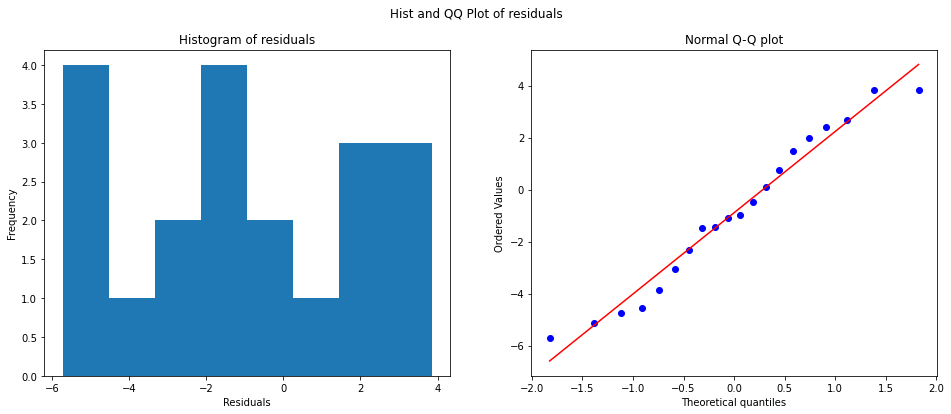

ShapiroResult(statistic=0.955881655216217, pvalue=0.4651930630207062)

In [51]:
fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].hist(residual1,bins=8)
axs[0].set_xlabel("Residuals")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of residuals")
fig.suptitle("Hist and QQ Plot of residuals")
stats.probplot(residual1, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

shapiro_test = stats.shapiro(residual1)
shapiro_test

(20.0, 0.394578182086001, nan, nan)


C:\Users\44747\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


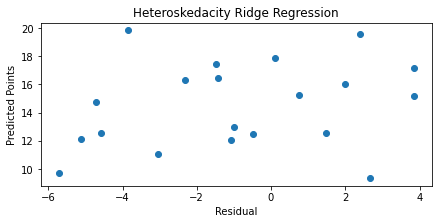

In [52]:
fig, ax = plt.subplots(figsize=(7,3))
ax.scatter(residual1, y_pred1)
# Variance of errors does seem constant
plt.xlabel("Residual")
plt.ylabel("Predicted Points")
plt.title("Heteroskedacity Ridge Regression")

white_test = het_white(residual1,  X_test1)
print(white_test)

# Principal Component Analysis

In [53]:
# Set features for PCA
cricket_features = cricket.drop(['Season', 'Team','Points'], axis=1)

In [54]:
# Standardise the data for PCA
cricket_features_S = StandardScaler().fit_transform(cricket_features)

In [55]:
cricketPCA = cricket

In [56]:
cricketPCA[['Avg_SR', 'RPG_Bat', 'PP_Batting_Avg', 'PP_Avg_WLost', 'RunsPWBat', 'BoundPG', 'DotsPG_Bat', 'Bowl_SR', 'RPB_Bowl', 'PP_Avg_RPB_Bowl', 'PP_Avg_Runs_Bowl', 'Death_Econ', 'Death_W', 'RunsPWBowl', 'WPG', 'AvgDots_PG_Bowl']] = StandardScaler().fit_transform(cricket_features[['Avg_SR', 'RPG_Bat', 'PP_Batting_Avg', 'PP_Avg_WLost', 'RunsPWBat', 'BoundPG', 'DotsPG_Bat', 'Bowl_SR', 'RPB_Bowl', 'PP_Avg_RPB_Bowl', 'PP_Avg_Runs_Bowl', 'Death_Econ', 'Death_W', 'RunsPWBowl', 'WPG', 'AvgDots_PG_Bowl']]) 

In [57]:
features = ['Avg_SR', 'RPG_Bat', 'PP_Batting_Avg', 'PP_Avg_WLost', 'RunsPWBat', 'BoundPG', 'DotsPG_Bat', 'Bowl_SR', 'RPB_Bowl', 'PP_Avg_RPB_Bowl', 'PP_Avg_Runs_Bowl', 'Death_Econ', 'Death_W', 'RunsPWBowl', 'WPG', 'AvgDots_PG_Bowl']

In [58]:
# Set parameters for PCA
x = cricketPCA.loc[:,features].values
y = cricketPCA.loc[:, ['Points']].values

In [59]:
# Fit the PCA
pca = PCA().fit(x)

Text(0.5, 1.0, 'PCA Feature Selection')

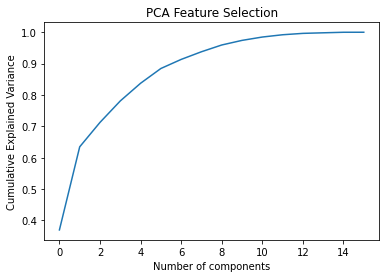

In [60]:
# Plot the exaplined variance ratio of PCA to determine optimum number of features
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Feature Selection")

In [61]:
# Run PCA with 9 features and create dataframe
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)
principaldf = pd.DataFrame(data = principalComponents, columns = ['pc1,', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9'])

In [62]:
finalDF = pd.concat([principaldf, cricketPCA[['Points']]], axis=1)

In [63]:
finalDF

,"pc1,",pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,Points
0,-0.711622,-0.973475,-1.050518,-1.235078,0.288954,0.747554,-0.362207,-0.048531,0.991622,16
1,0.452553,-1.952041,0.325507,0.076510,-1.178471,0.327859,0.288179,-1.274658,-1.141612,17
2,0.043742,-1.752236,-0.745129,0.663576,0.263522,-0.215816,0.442000,0.355392,-0.625452,14
3,0.466522,-0.623715,-0.183177,-1.798653,-0.643105,1.293695,-0.178840,1.353507,-0.695138,18
4,0.704764,-1.096263,0.432408,-2.349433,0.928963,0.577386,-0.165971,-0.853931,-0.057277,17
...,...,...,...,...,...,...,...,...,...,...
95,-1.084976,0.323559,0.811606,-0.606334,-0.008536,-0.269361,0.255433,-0.455029,0.200057,14
96,-0.015686,-0.467474,-0.323761,-1.205586,-0.844559,0.319404,-0.069839,-0.785766,0.773074,16
97,-2.419689,-3.945941,0.890175,-1.932153,-0.002513,0.631470,-1.263426,0.262858,0.185811,17
98,-1.075225,-0.847983,0.210066,0.250393,0.362465,-0.132371,0.786376,0.149217,-0.664713,18


In [64]:
pca.explained_variance_ratio_

array([0.36973902, 0.2649469 , 0.07789341, 0.06842046, 0.05635183,
       0.04707164, 0.02895567, 0.02443533, 0.02155797])

In [65]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([36.97, 63.46, 71.25, 78.09, 83.73, 88.44, 91.34, 93.78, 95.94])

In [66]:
# Divide into test and train
df_train, df_test = train_test_split(finalDF, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 100)

In [67]:
# Define training and test based on PCA dataframe
y_train2 = df_train.pop('Points')
X_train2 = df_train

y_test2 = df_test.pop('Points')
X_test2 = df_test

In [68]:
# Fir the regression model
lm = LinearRegression()
lm.fit(X_train2, y_train2)

LinearRegression()

In [69]:
# Get r2 value for PCA regressio 
y_pred2 = lm.predict(X_test2)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test2, y_pred2)
print(r2)

0.6838686538195695


In [70]:
# Should I reference this?
explained_variance=metrics.explained_variance_score(y_test2, y_pred2)
mean_absolute_error=metrics.mean_absolute_error(y_test2, y_pred2) 
mse=metrics.mean_squared_error(y_test2, y_pred2) 
mean_squared_log_error=metrics.mean_squared_log_error(y_test2, y_pred2)
median_absolute_error=metrics.median_absolute_error(y_test2, y_pred2)
r2=metrics.r2_score(y_test2, y_pred2)

In [71]:
print('explained_variance: ', round(explained_variance,4))    
print('mean_squared_log_error: ', round(mean_squared_log_error,4))
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

explained_variance:  0.6843
mean_squared_log_error:  0.0453
r2:  0.6839
MAE:  2.2185
MSE:  6.932
RMSE:  2.6329


In [72]:
# Cross validate the PCA model
X  = finalDF[['pc1,', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9']]
y= finalDF['Points']
model = LinearRegression()
accuracy = cross_val_score(model, X, y, scoring='r2', cv = 5)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.41515154 0.54674786 0.56405126 0.46321506 0.46665626]
Accuracy of Model with Cross Validation is: 49.11643940536431


In [73]:
residual2 = y_test2 - y_pred2

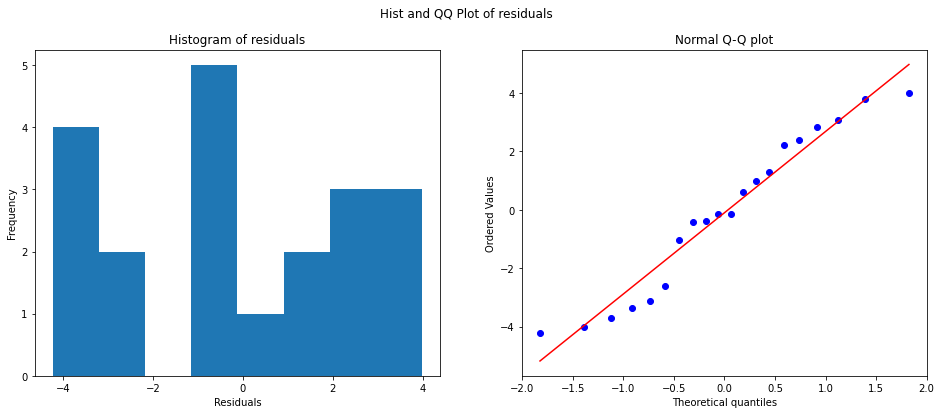

ShapiroResult(statistic=0.9362546801567078, pvalue=0.20354105532169342)

In [74]:
fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].hist(residual2,bins=8)
axs[0].set_xlabel("Residuals")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of residuals")
fig.suptitle("Hist and QQ Plot of residuals")
stats.probplot(residual2, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

shapiro_test = stats.shapiro(residual2)
shapiro_test

(20.0, 0.394578182086001, nan, nan)


C:\Users\44747\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


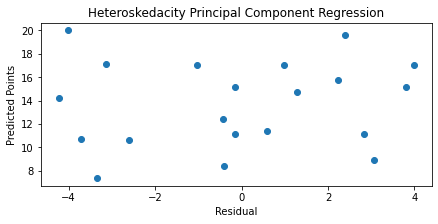

In [75]:
fig, ax = plt.subplots(figsize=(7,3))
ax.scatter(residual2, y_pred2)
plt.xlabel("Residual")
plt.ylabel("Predicted Points")
plt.title("Heteroskedacity Principal Component Regression")
# Variance of errors does seem constant

white_test = het_white(residual2,  X_test2)
print(white_test)